In [60]:
#import relevant libraries
import pandas as pd
pd.set_option('max_colwidth', 400)
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import RegexpTokenizer, sent_tokenize, word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords', quiet=True)
from nltk.stem import PorterStemmer, SnowballStemmer
from nltk import FreqDist, pos_tag
nltk.download('punkt', quiet=True)
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('wordnet')
from nltk.sentiment.vader import SentimentIntensityAnalyzer


from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay 
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/andrewreusche/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
"""
possible project order

define problem 
collect data
preprocess data
exploratory data analysis
model selection (logistic, niave bayes, support vector machines, neural networks)
train model 
tune model
model eval
"""

'\npossible project order\n\ndefine problem \ncollect data\npreprocess data\nexploratory data analysis\nmodel selection (logistic, niave bayes, support vector machines, neural networks)\ntrain model \ntune model\nmodel eval\n'

In [3]:
#thoughts: maybe lemmetize instead of stemming for higher accuracy

In [4]:
df= pd.read_csv('data/judge-1377884607_tweet_product_company.csv', encoding='ISO-8859-1')

In [5]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative emotion
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative emotion
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive emotion


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [7]:
#there seems to be only one missing tweet from 9093 instances so we will just drop that.
#the product category column is missing over 2/3 of the data so we will drop that as well

In [8]:
#create a new df with just the data we want
raw_df= df[['tweet_text','is_there_an_emotion_directed_at_a_brand_or_product']]

In [9]:
raw_df.head()

,tweet_text,is_there_an_emotion_directed_at_a_brand_or_product
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",Negative emotion
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,Positive emotion
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,Negative emotion
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Positive emotion


In [10]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 2 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(2)
memory usage: 142.2+ KB


In [11]:
raw_df= raw_df.dropna()

In [12]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9092 entries, 0 to 9092
Data columns (total 2 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   is_there_an_emotion_directed_at_a_brand_or_product  9092 non-null   object
dtypes: object(2)
memory usage: 213.1+ KB


In [13]:
# I believe that all the tweets start with the twitter handle lets look
raw_df['tweet_text'][:100]

0                  .@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.
1      @jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW
2                                                                  @swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.
3                                                               @sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw
4              @sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)
                                                                          ...                                                                     
96                      Yai!!! RT @mention New #UberSocial for #iPhone now in the App Store includes UberGuide to #SXS

In [14]:
#this seems to be a false hypothesis, but the analysis might benefitting us from dropping the @names as part of the
#stop words. They are just names and don't really hint at sentiment.


In [15]:
#check for duplicates
raw_df = raw_df.drop_duplicates(keep='first')
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9070 entries, 0 to 9092
Data columns (total 2 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9070 non-null   object
 1   is_there_an_emotion_directed_at_a_brand_or_product  9070 non-null   object
dtypes: object(2)
memory usage: 212.6+ KB


In [16]:
#it seems there were 22 duplicates, we removed them

In [17]:
#lets rename the columns to more convienient nmames
raw_df = raw_df.rename(columns={'tweet_text': 'tweet', 
                                'is_there_an_emotion_directed_at_a_brand_or_product': 'sentiment'})
raw_df.head()

,tweet,sentiment
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",Negative emotion
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,Positive emotion
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,Negative emotion
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Positive emotion


In [18]:
#lets check out the sentiment distribution to see if it is relatively ever or skewed
raw_df['sentiment'].value_counts()

sentiment
No emotion toward brand or product    5375
Positive emotion                      2970
Negative emotion                       569
I can't tell                           156
Name: count, dtype: int64

In [47]:
raw_df['sentiment'].value_counts(normalize= True)

sentiment
No emotion toward brand or product    0.592613
Positive emotion                      0.327453
Negative emotion                      0.062734
I can't tell                          0.017200
Name: proportion, dtype: float64

In [19]:
#lets see if we can shed any light on the "I can't tell" instances 
raw_df['tweet'][raw_df['sentiment'] == "I can't tell"].head()  

90                Thanks to @mention for publishing the news of @mention new medical Apps at the #sxswi conf. blog {link} #sxsw #sxswh
102    ÛÏ@mention &quot;Apple has opened a pop-up store in Austin so the nerds in town for #SXSW can get their new iPads. {link} #wow
237         Just what America needs. RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw
341                                                     The queue at the Apple Store in Austin is FOUR blocks long. Crazy stuff! #sxsw
368                  Hope it's better than wave RT @mention Buzz is: Google's previewing a social networking platform at #SXSW: {link}
Name: tweet, dtype: object

In [20]:
#get rid of all instances of 'couldn't tell'
rel_raw_df = raw_df[raw_df['sentiment'] != "I can't tell"]
rel_raw_df['sentiment'].value_counts()

sentiment
No emotion toward brand or product    5375
Positive emotion                      2970
Negative emotion                       569
Name: count, dtype: int64

In [48]:
rel_raw_df['sentiment'].value_counts(normalize= True)

sentiment
No emotion toward brand or product    0.602984
Positive emotion                      0.333184
Negative emotion                      0.063832
Name: proportion, dtype: float64

In [21]:
#lower all the text strings
rel_raw_df["tweet"] = rel_raw_df["tweet"].str.lower()
rel_raw_df[:10]

/var/folders/p_/7g5qyc8d5zv5nfywm65yhpkc0000gn/T/ipykernel_50345/785506546.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rel_raw_df["tweet"] = rel_raw_df["tweet"].str.lower()


,tweet,sentiment
0,".@wesley83 i have a 3g iphone. after 3 hrs tweeting at #rise_austin, it was dead! i need to upgrade. plugin stations at #sxsw.",Negative emotion
1,"@jessedee know about @fludapp ? awesome ipad/iphone app that you'll likely appreciate for its design. also, they're giving free ts at #sxsw",Positive emotion
2,@swonderlin can not wait for #ipad 2 also. they should sale them down at #sxsw.,Positive emotion
3,@sxsw i hope this year's festival isn't as crashy as this year's iphone app. #sxsw,Negative emotion
4,"@sxtxstate great stuff on fri #sxsw: marissa mayer (google), tim o'reilly (tech books/conferences) &amp; matt mullenweg (wordpress)",Positive emotion
5,@teachntech00 new ipad apps for #speechtherapy and communication are showcased at the #sxsw conference http://ht.ly/49n4m #iear #edchat #asd,No emotion toward brand or product
7,"#sxsw is just starting, #ctia is around the corner and #googleio is only a hop skip and a jump from there, good time to be an #android fan",Positive emotion
8,beautifully smart and simple idea rt @madebymany @thenextweb wrote about our #hollergram ipad app for #sxsw! http://bit.ly/ieavob,Positive emotion
9,counting down the days to #sxsw plus strong canadian dollar means stock up on apple gear,Positive emotion
10,excited to meet the @samsungmobileus at #sxsw so i can show them my sprint galaxy s still running android 2.1. #fail,Positive emotion


In [22]:
rel_raw_df[10:25]

,tweet,sentiment
11,find &amp; start impromptu parties at #sxsw with @hurricaneparty http://bit.ly/gvlrin i can't wait til the android app comes out.,Positive emotion
12,"foursquare ups the game, just in time for #sxsw http://j.mp/grn7pk) - still prefer @gowalla by far, best looking android app to date.",Positive emotion
13,gotta love this #sxsw google calendar featuring top parties/ show cases to check out. rt @hamsandwich via @ischafer =&gt;http://bit.ly/axzwxb,Positive emotion
14,great #sxsw ipad app from @madebymany: http://tinyurl.com/4nqv92l,Positive emotion
15,"haha, awesomely rad ipad app by @madebymany http://bit.ly/htdfim #hollergram #sxsw",Positive emotion
16,holler gram for ipad on the itunes app store - http://t.co/kfn3f5q (via @marc_is_ken) #sxsw,No emotion toward brand or product
17,i just noticed dst is coming this weekend. how many iphone users will be an hour late at sxsw come sunday morning? #sxsw #iphone,Negative emotion
18,"just added my #sxsw flights to @planely. matching people on planes/airports. also downloaded the @klm iphone app, nicely done.",Positive emotion
19,must have #sxsw app! rt @malbonster: lovely review from forbes for our sxsw ipad app holler gram - http://t.co/g4gzypv,Positive emotion
20,need to buy an ipad2 while i'm in austin at #sxsw. not sure if i'll need to q up at an austin apple store?,Positive emotion


In [23]:
#what I still need to do
#get rid of all the # and . and other that I don't want
#lemmetize the words

In [24]:
#find the optimal regular expression (regex) pattern pattern 
#I am opting to get rid of URL's because I am trying to find sentiment not platform or item and links are hardly a mood descriptor
#for the same reason I would like to get rid of the # in front of words so the 'hate' is not seen as different from '#hate'

In [25]:
#current regular expression pattern r'(@\w+|#\w+|http\S+|\w+|\d+)'
#v2 remove general urls: r'(@\w+|#\w+|\w+|\d+)(?!\S*http\S+)'
#unsure wether to keep/ remove, or modify @'s
#v3 removes the @ from @name to just be name: r'(@?[\w]+|#\w+|\w+|\d+)(?!\S*http\S+)' 
#v4 get rid of # before words : r'(@?[\w]+|#?[\w]+|\w+|\d+)(?!\S*http\S+)' this may help or hurt
#v5: r'(@?[\w]+|#?[\w]+|\w+|\d+)(?!\S*http\S+)'
#v6 r'[@#]?\w+(?!\S*http\S+)'
#v7 r'[@#]?(\w+)' #mostly works but some errors
#v8 r'http[s]?://\S+|www\.\S+|[@#]?\w+' #gets rid of links but shows @ and #
#v9 r'(?:(?:https?://|www)\S+)|(?:#(\w+))|(?:@(\w+))|(\w+|\S)' #technically does both but outputs multiple spaces around the token
#v10 r'(?<!\S)(?:[@#])?(\w+)(?!\S*[://])' #closest thing i have so far, experiencing some error when . is in front of @
#v11 r'(?<!\S)(?:\.?[@#])?(\w+)(?!\S*[://])' this seems to do everything I need, doesn't do (word) or &word
#v12  r'(?<!\S)(?:\.?[@#])?(\w+)(?![^\s()]*[://])' didn't do anything better or worse 
#v13   r'(?<![\w:.])(?:\.?[@#])?(\w+)' this successfully gets rid of the (word) / &word problem but doesn't get rid of links anymore
#v14   r'(?:http[s]?://\S+|www\.\S+)|(?<![\w:.])(?:\.?[@#])?(\w+)' this seems to be the catch all for @ # () & and links 
#the only problem is that the link leaves a '' so we will need to drop that in the bag of words 

In [50]:
#define the token extraction pattern
token_pattern=  r'(?:http[s]?://\S+|www\.\S+)|(?<![\w:.])(?:\.?[@#])?(\w+)'
"""
(?:http[s]?://\S+|www\.\S+) makes sure any urls that start with hhtp, https, or www are all passed over
(?<![\w:.]) a negative lookbehind to make sure the current potential token being looked at is not part of a larger token?
(?:\.?[@#])?  skips over any ".", "@", or "#" that may be in front of a word
(\w+) sucks up any words with 1 or more letters in a row 
"""
tokenizer= RegexpTokenizer(token_pattern)

In [27]:
#grab a sample
samp1= rel_raw_df['tweet'][5]
samp1

'@teachntech00 new ipad apps for #speechtherapy and communication are showcased at the #sxsw conference http://ht.ly/49n4m #iear #edchat #asd'

In [28]:
samp1.split()

['@teachntech00',
 'new',
 'ipad',
 'apps',
 'for',
 '#speechtherapy',
 'and',
 'communication',
 'are',
 'showcased',
 'at',
 'the',
 '#sxsw',
 'conference',
 'http://ht.ly/49n4m',
 '#iear',
 '#edchat',
 '#asd']

In [29]:
tokenizer.tokenize(samp1)

['teachntech00',
 'new',
 'ipad',
 'apps',
 'for',
 'speechtherapy',
 'and',
 'communication',
 'are',
 'showcased',
 'at',
 'the',
 'sxsw',
 'conference',
 '',
 'iear',
 'edchat',
 'asd']

In [30]:
samp2= rel_raw_df['tweet'][10]
samp2

'excited to meet the @samsungmobileus at #sxsw so i can show them my sprint galaxy s still running android 2.1.   #fail'

In [31]:
samp2.split()

['excited',
 'to',
 'meet',
 'the',
 '@samsungmobileus',
 'at',
 '#sxsw',
 'so',
 'i',
 'can',
 'show',
 'them',
 'my',
 'sprint',
 'galaxy',
 's',
 'still',
 'running',
 'android',
 '2.1.',
 '#fail']

In [32]:
tokenizer.tokenize(samp2)

['excited',
 'to',
 'meet',
 'the',
 'samsungmobileus',
 'at',
 'sxsw',
 'so',
 'i',
 'can',
 'show',
 'them',
 'my',
 'sprint',
 'galaxy',
 's',
 'still',
 'running',
 'android',
 '2',
 'fail']

In [33]:
samp3= rel_raw_df['tweet'][0]
samp3

'.@wesley83 i have a 3g iphone. after 3 hrs tweeting at #rise_austin, it was dead!  i need to upgrade. plugin stations at #sxsw.'

In [34]:
samp3.split()

['.@wesley83',
 'i',
 'have',
 'a',
 '3g',
 'iphone.',
 'after',
 '3',
 'hrs',
 'tweeting',
 'at',
 '#rise_austin,',
 'it',
 'was',
 'dead!',
 'i',
 'need',
 'to',
 'upgrade.',
 'plugin',
 'stations',
 'at',
 '#sxsw.']

In [35]:
tokenizer.tokenize(samp3)

['wesley83',
 'i',
 'have',
 'a',
 '3g',
 'iphone',
 'after',
 '3',
 'hrs',
 'tweeting',
 'at',
 'rise_austin',
 'it',
 'was',
 'dead',
 'i',
 'need',
 'to',
 'upgrade',
 'plugin',
 'stations',
 'at',
 'sxsw']

In [36]:
#lets test this pattern on some other strings 


In [37]:
samp4= rel_raw_df['tweet'][4]
samp4

"@sxtxstate great stuff on fri #sxsw: marissa mayer (google), tim o'reilly (tech books/conferences) &amp; matt mullenweg (wordpress)"

In [38]:
tokenizer.tokenize(samp4)

['sxtxstate',
 'great',
 'stuff',
 'on',
 'fri',
 'sxsw',
 'marissa',
 'mayer',
 'google',
 'tim',
 'o',
 'reilly',
 'tech',
 'books',
 'conferences',
 'amp',
 'matt',
 'mullenweg',
 'wordpress']

In [39]:
samp5= rel_raw_df['tweet'][22]
samp5

'okay, this is really it: yay new @foursquare for #android app!!!!11 kthxbai. #sxsw'

In [40]:
tokenizer.tokenize(samp5)

['okay',
 'this',
 'is',
 'really',
 'it',
 'yay',
 'new',
 'foursquare',
 'for',
 'android',
 'app',
 '11',
 'kthxbai',
 'sxsw']

In [41]:
#tokenize the full dataset now 
rel_raw_df["tweet_tokenized"] = rel_raw_df["tweet"].apply(tokenizer.tokenize)
rel_raw_df.head()

/var/folders/p_/7g5qyc8d5zv5nfywm65yhpkc0000gn/T/ipykernel_50345/3090715720.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rel_raw_df["tweet_tokenized"] = rel_raw_df["tweet"].apply(tokenizer.tokenize)


,tweet,sentiment,tweet_tokenized
0,".@wesley83 i have a 3g iphone. after 3 hrs tweeting at #rise_austin, it was dead! i need to upgrade. plugin stations at #sxsw.",Negative emotion,"[wesley83, i, have, a, 3g, iphone, after, 3, hrs, tweeting, at, rise_austin, it, was, dead, i, need, to, upgrade, plugin, stations, at, sxsw]"
1,"@jessedee know about @fludapp ? awesome ipad/iphone app that you'll likely appreciate for its design. also, they're giving free ts at #sxsw",Positive emotion,"[jessedee, know, about, fludapp, awesome, ipad, iphone, app, that, you, ll, likely, appreciate, for, its, design, also, they, re, giving, free, ts, at, sxsw]"
2,@swonderlin can not wait for #ipad 2 also. they should sale them down at #sxsw.,Positive emotion,"[swonderlin, can, not, wait, for, ipad, 2, also, they, should, sale, them, down, at, sxsw]"
3,@sxsw i hope this year's festival isn't as crashy as this year's iphone app. #sxsw,Negative emotion,"[sxsw, i, hope, this, year, s, festival, isn, t, as, crashy, as, this, year, s, iphone, app, sxsw]"
4,"@sxtxstate great stuff on fri #sxsw: marissa mayer (google), tim o'reilly (tech books/conferences) &amp; matt mullenweg (wordpress)",Positive emotion,"[sxtxstate, great, stuff, on, fri, sxsw, marissa, mayer, google, tim, o, reilly, tech, books, conferences, amp, matt, mullenweg, wordpress]"


In [42]:
#remove the stop words
stopwords_list= stopwords.words('english')

def remove_stopwords(token_list):
    list_stripped= [x for x in token_list if x not in stopwords_list]
    return list_stripped

rel_raw_df["tweet_tokenized_ns"] = rel_raw_df["tweet_tokenized"].apply(remove_stopwords)

print('previous tokens')
print(rel_raw_df["tweet_tokenized"].head())
print()
print('ns tokens')
print(rel_raw_df["tweet_tokenized_ns"].head())

previous tokens
0                    [wesley83, i, have, a, 3g, iphone, after, 3, hrs, tweeting, at, rise_austin, it, was, dead, i, need, to, upgrade, plugin, stations, at, sxsw]
1    [jessedee, know, about, fludapp, awesome, ipad, iphone, app, that, you, ll, likely, appreciate, for, its, design, also, they, re, giving, free, ts, at, sxsw]
2                                                                       [swonderlin, can, not, wait, for, ipad, 2, also, they, should, sale, them, down, at, sxsw]
3                                                               [sxsw, i, hope, this, year, s, festival, isn, t, as, crashy, as, this, year, s, iphone, app, sxsw]
4                      [sxtxstate, great, stuff, on, fri, sxsw, marissa, mayer, google, tim, o, reilly, tech, books, conferences, amp, matt, mullenweg, wordpress]
Name: tweet_tokenized, dtype: object

ns tokens
0                                      [wesley83, 3g, iphone, 3, hrs, tweeting, rise_austin, dead, need, upgrade, plugin,

/var/folders/p_/7g5qyc8d5zv5nfywm65yhpkc0000gn/T/ipykernel_50345/2527271126.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rel_raw_df["tweet_tokenized_ns"] = rel_raw_df["tweet_tokenized"].apply(remove_stopwords)


In [43]:
#lemmetize the tokens
lemmatizer = WordNetLemmatizer()

def lem_tokens(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

rel_raw_df["tweet_lem"] = rel_raw_df["tweet_tokenized_ns"].apply(lem_tokens)

print('ns tokens')
print(rel_raw_df["tweet_tokenized_ns"].head())
print()
print('lem tokens')
print(rel_raw_df["tweet_lem"].head())

ns tokens
0                                      [wesley83, 3g, iphone, 3, hrs, tweeting, rise_austin, dead, need, upgrade, plugin, stations, sxsw]
1                         [jessedee, know, fludapp, awesome, ipad, iphone, app, likely, appreciate, design, also, giving, free, ts, sxsw]
2                                                                                           [swonderlin, wait, ipad, 2, also, sale, sxsw]
3                                                                           [sxsw, hope, year, festival, crashy, year, iphone, app, sxsw]
4    [sxtxstate, great, stuff, fri, sxsw, marissa, mayer, google, tim, reilly, tech, books, conferences, amp, matt, mullenweg, wordpress]
Name: tweet_tokenized_ns, dtype: object

lem tokens
0                                      [wesley83, 3g, iphone, 3, hr, tweeting, rise_austin, dead, need, upgrade, plugin, station, sxsw]
1                        [jessedee, know, fludapp, awesome, ipad, iphone, app, likely, appreciate, design, also,

/var/folders/p_/7g5qyc8d5zv5nfywm65yhpkc0000gn/T/ipykernel_50345/2582844597.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rel_raw_df["tweet_lem"] = rel_raw_df["tweet_tokenized_ns"].apply(lem_tokens)


In [44]:
#check to see if anthing was changed, it was 
rel_raw_df["tweet_lem"]==rel_raw_df["tweet_tokenized_ns"]

0       False
1       False
2        True
3        True
4       False
        ...  
9088     True
9089    False
9090    False
9091    False
9092    False
Length: 8914, dtype: bool

In [45]:
#train val test split

In [49]:
rel_raw_df['sentiment'].value_counts(normalize= True)

sentiment
No emotion toward brand or product    0.602984
Positive emotion                      0.333184
Negative emotion                      0.063832
Name: proportion, dtype: float64

In [63]:
#do a stratified validation split

In [64]:
rel_raw_df.head()

,tweet,sentiment,tweet_tokenized,tweet_tokenized_ns,tweet_lem
0,".@wesley83 i have a 3g iphone. after 3 hrs tweeting at #rise_austin, it was dead! i need to upgrade. plugin stations at #sxsw.",Negative emotion,"[wesley83, i, have, a, 3g, iphone, after, 3, hrs, tweeting, at, rise_austin, it, was, dead, i, need, to, upgrade, plugin, stations, at, sxsw]","[wesley83, 3g, iphone, 3, hrs, tweeting, rise_austin, dead, need, upgrade, plugin, stations, sxsw]","[wesley83, 3g, iphone, 3, hr, tweeting, rise_austin, dead, need, upgrade, plugin, station, sxsw]"
1,"@jessedee know about @fludapp ? awesome ipad/iphone app that you'll likely appreciate for its design. also, they're giving free ts at #sxsw",Positive emotion,"[jessedee, know, about, fludapp, awesome, ipad, iphone, app, that, you, ll, likely, appreciate, for, its, design, also, they, re, giving, free, ts, at, sxsw]","[jessedee, know, fludapp, awesome, ipad, iphone, app, likely, appreciate, design, also, giving, free, ts, sxsw]","[jessedee, know, fludapp, awesome, ipad, iphone, app, likely, appreciate, design, also, giving, free, t, sxsw]"
2,@swonderlin can not wait for #ipad 2 also. they should sale them down at #sxsw.,Positive emotion,"[swonderlin, can, not, wait, for, ipad, 2, also, they, should, sale, them, down, at, sxsw]","[swonderlin, wait, ipad, 2, also, sale, sxsw]","[swonderlin, wait, ipad, 2, also, sale, sxsw]"
3,@sxsw i hope this year's festival isn't as crashy as this year's iphone app. #sxsw,Negative emotion,"[sxsw, i, hope, this, year, s, festival, isn, t, as, crashy, as, this, year, s, iphone, app, sxsw]","[sxsw, hope, year, festival, crashy, year, iphone, app, sxsw]","[sxsw, hope, year, festival, crashy, year, iphone, app, sxsw]"
4,"@sxtxstate great stuff on fri #sxsw: marissa mayer (google), tim o'reilly (tech books/conferences) &amp; matt mullenweg (wordpress)",Positive emotion,"[sxtxstate, great, stuff, on, fri, sxsw, marissa, mayer, google, tim, o, reilly, tech, books, conferences, amp, matt, mullenweg, wordpress]","[sxtxstate, great, stuff, fri, sxsw, marissa, mayer, google, tim, reilly, tech, books, conferences, amp, matt, mullenweg, wordpress]","[sxtxstate, great, stuff, fri, sxsw, marissa, mayer, google, tim, reilly, tech, book, conference, amp, matt, mullenweg, wordpress]"


In [66]:
#make a new df column that associates sentiment with a number
sentiment_map = {'No emotion toward brand or product': 0,
    'Positive emotion': 1,
    'Negative emotion': 2}

rel_raw_df['sentiment_num'] = rel_raw_df['sentiment'].map(sentiment_map)

rel_raw_df.head()

/var/folders/p_/7g5qyc8d5zv5nfywm65yhpkc0000gn/T/ipykernel_50345/3461673320.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rel_raw_df['sentiment_num'] = rel_raw_df['sentiment'].map(sentiment_map)


,tweet,sentiment,tweet_tokenized,tweet_tokenized_ns,tweet_lem,sentiment_num
0,".@wesley83 i have a 3g iphone. after 3 hrs tweeting at #rise_austin, it was dead! i need to upgrade. plugin stations at #sxsw.",Negative emotion,"[wesley83, i, have, a, 3g, iphone, after, 3, hrs, tweeting, at, rise_austin, it, was, dead, i, need, to, upgrade, plugin, stations, at, sxsw]","[wesley83, 3g, iphone, 3, hrs, tweeting, rise_austin, dead, need, upgrade, plugin, stations, sxsw]","[wesley83, 3g, iphone, 3, hr, tweeting, rise_austin, dead, need, upgrade, plugin, station, sxsw]",2
1,"@jessedee know about @fludapp ? awesome ipad/iphone app that you'll likely appreciate for its design. also, they're giving free ts at #sxsw",Positive emotion,"[jessedee, know, about, fludapp, awesome, ipad, iphone, app, that, you, ll, likely, appreciate, for, its, design, also, they, re, giving, free, ts, at, sxsw]","[jessedee, know, fludapp, awesome, ipad, iphone, app, likely, appreciate, design, also, giving, free, ts, sxsw]","[jessedee, know, fludapp, awesome, ipad, iphone, app, likely, appreciate, design, also, giving, free, t, sxsw]",1
2,@swonderlin can not wait for #ipad 2 also. they should sale them down at #sxsw.,Positive emotion,"[swonderlin, can, not, wait, for, ipad, 2, also, they, should, sale, them, down, at, sxsw]","[swonderlin, wait, ipad, 2, also, sale, sxsw]","[swonderlin, wait, ipad, 2, also, sale, sxsw]",1
3,@sxsw i hope this year's festival isn't as crashy as this year's iphone app. #sxsw,Negative emotion,"[sxsw, i, hope, this, year, s, festival, isn, t, as, crashy, as, this, year, s, iphone, app, sxsw]","[sxsw, hope, year, festival, crashy, year, iphone, app, sxsw]","[sxsw, hope, year, festival, crashy, year, iphone, app, sxsw]",2
4,"@sxtxstate great stuff on fri #sxsw: marissa mayer (google), tim o'reilly (tech books/conferences) &amp; matt mullenweg (wordpress)",Positive emotion,"[sxtxstate, great, stuff, on, fri, sxsw, marissa, mayer, google, tim, o, reilly, tech, books, conferences, amp, matt, mullenweg, wordpress]","[sxtxstate, great, stuff, fri, sxsw, marissa, mayer, google, tim, reilly, tech, books, conferences, amp, matt, mullenweg, wordpress]","[sxtxstate, great, stuff, fri, sxsw, marissa, mayer, google, tim, reilly, tech, book, conference, amp, matt, mullenweg, wordpress]",1


In [67]:
#set x and y 
X= rel_raw_df['tweet_lem']
y= rel_raw_df['sentiment_num']

In [74]:
#stratified train and test split to maintain the same target distrobution ratios
#i want 80% training data, 10% validation data, and 10% test data 

#Train split (remain is the remaining data)
X_train, X_remain, y_train, y_remain= train_test_split(X, y, 
                                                   test_size= 0.2, 
                                                   stratify= y, 
                                                   random_state= 24)

#Val test split 
X_val, X_test, y_val, y_test= train_test_split(X_remain, y_remain,
                                               test_size= 0.5,
                                               stratify= y_remain, 
                                               random_state= 24)

In [75]:
X_train.head()

1513                 [omarg, rumor, apple, opening, temporary, store, downtown, austin, sxsw, ipad, 2, launch, link]
6726                                                          [rt, mention, ipad, 2, take, sxsw, video, link, sxswi]
9057     [mention, guy, amp, give, ipad, win, quot, mention, cbs, scvngr, launch, spy, game, sxsw, link, sxsw, quot]
6815    [rt, mention, toptweets, rt, mention, rumor, apple, opening, temporary, store, downtown, austin, sxsw, link]
6733                             [rt, mention, apple, pop, store, line, finally, dwindled, time, check, ipad2, sxsw]
Name: tweet_lem, dtype: object

/var/folders/p_/7g5qyc8d5zv5nfywm65yhpkc0000gn/T/ipykernel_50345/2372018249.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(words, rotation=45, ha='right')


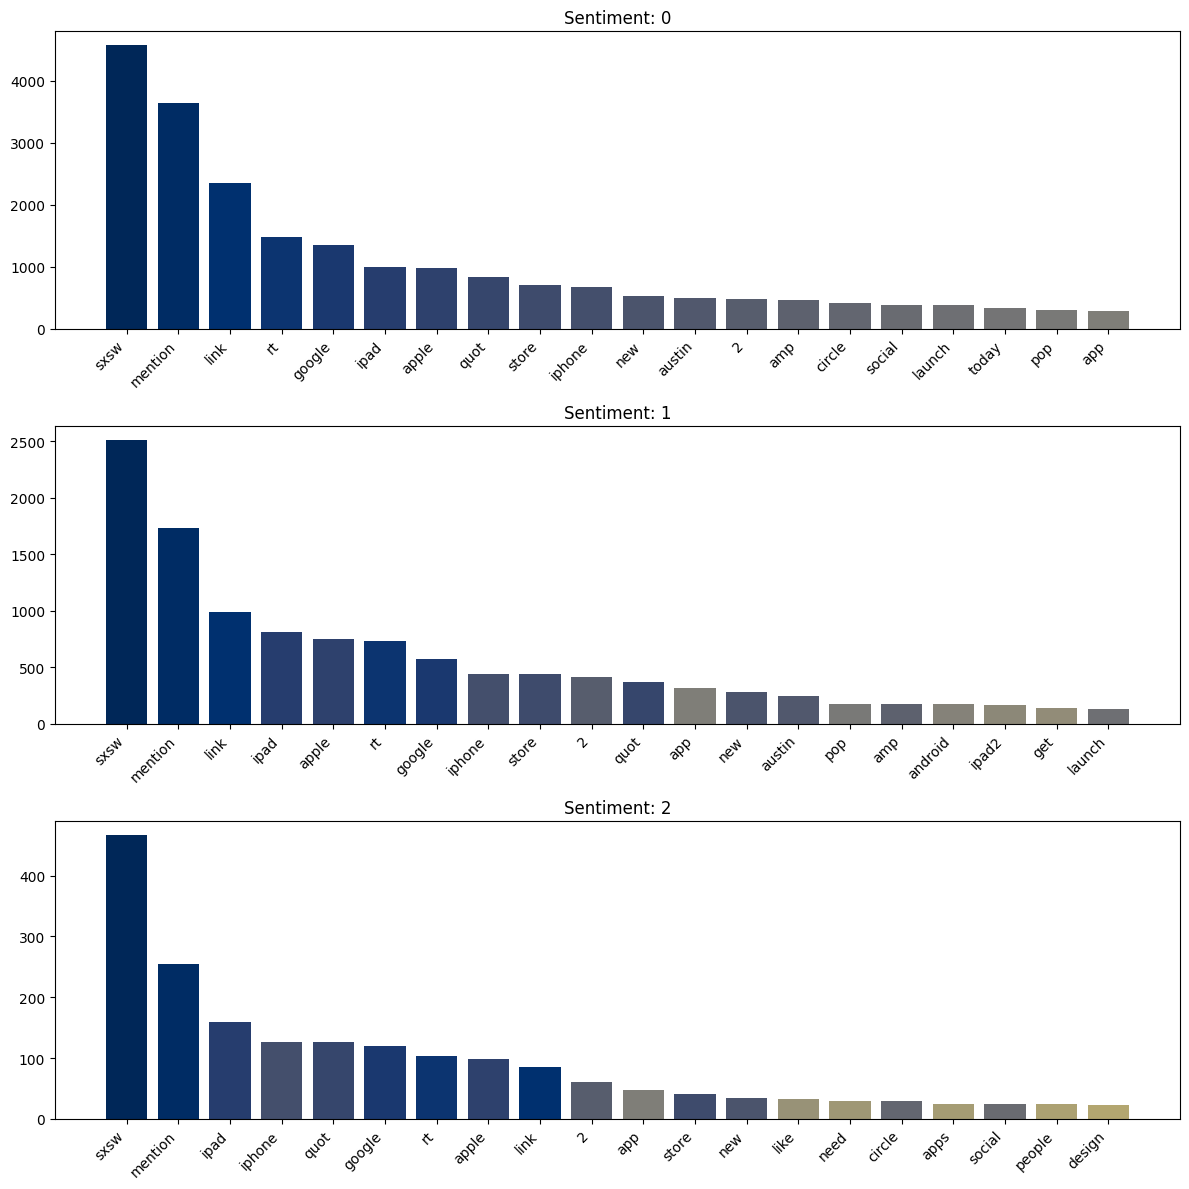

In [80]:
#check out the word distrobutions in X_train for each target class

from collections import Counter

color_palette = sns.color_palette('cividis', n_colors=38)

fig, axes = plt.subplots(nrows=3, figsize=(12, 12)) 

plotted_words_and_colors = {}

sentiment_classes = y_train.unique() 
for i, sentiment_class in enumerate(sentiment_classes):
    sentiment_data = X_train[y_train == sentiment_class]
    all_words_in_sentiment = [word for tokens in sentiment_data for word in tokens]
    top_10 = Counter(all_words_in_sentiment).most_common(20)
    
    colors = []
    
    for word, _ in top_10:
        if word not in plotted_words_and_colors:
            new_color = color_palette.pop(0)
            plotted_words_and_colors[word] = new_color
        colors.append(plotted_words_and_colors[word])
    
    ax = axes[i]
    words, counts = zip(*top_10)
    ax.bar(words, counts, color=colors)
    ax.set_title(f'Sentiment: {sentiment_class}') 
    ax.set_xticklabels(words, rotation=45, ha='right')

fig.tight_layout() 
plt.show()

In [ ]:
#it looks like we have a bunch of overlapping words that don't really have much to do with sentiment. 
#lets add them to our stop word list and get rid of them


In [81]:
#what if we get rid of all the @'s, numbers, and #'s in the tokenization 
##define the token extraction pattern
token_pattern2=  r'(?:http[s]?://\S+|www\.\S+|[@#]\w+|\b\d+\w*\b)|(?<![\w:.])(\b[a-zA-Z]+\b)'
"""
 
"""
tokenizer2= RegexpTokenizer(token_pattern2)
tokenizer2.tokenize(samp1)

['',
 'new',
 'ipad',
 'apps',
 'for',
 '',
 'and',
 'communication',
 'are',
 'showcased',
 'at',
 'the',
 '',
 'conference',
 '',
 '',
 '',
 '']

In [82]:
samp1

'@teachntech00 new ipad apps for #speechtherapy and communication are showcased at the #sxsw conference http://ht.ly/49n4m #iear #edchat #asd'

In [83]:
tokenizer2.tokenize(samp2)

['excited',
 'to',
 'meet',
 'the',
 '',
 'at',
 '',
 'so',
 'i',
 'can',
 'show',
 'them',
 'my',
 'sprint',
 'galaxy',
 's',
 'still',
 'running',
 'android',
 '',
 '',
 '']

In [84]:
samp2

'excited to meet the @samsungmobileus at #sxsw so i can show them my sprint galaxy s still running android 2.1.   #fail'

In [85]:
#tokenize the full dataset now 
rel_raw_df["tweet_tokenized2"] = rel_raw_df["tweet"].apply(tokenizer2.tokenize)
rel_raw_df.head()

/var/folders/p_/7g5qyc8d5zv5nfywm65yhpkc0000gn/T/ipykernel_50345/3613001294.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rel_raw_df["tweet_tokenized2"] = rel_raw_df["tweet"].apply(tokenizer2.tokenize)


,tweet,sentiment,tweet_tokenized,tweet_tokenized_ns,tweet_lem,sentiment_num,tweet_tokenized2
0,".@wesley83 i have a 3g iphone. after 3 hrs tweeting at #rise_austin, it was dead! i need to upgrade. plugin stations at #sxsw.",Negative emotion,"[wesley83, i, have, a, 3g, iphone, after, 3, hrs, tweeting, at, rise_austin, it, was, dead, i, need, to, upgrade, plugin, stations, at, sxsw]","[wesley83, 3g, iphone, 3, hrs, tweeting, rise_austin, dead, need, upgrade, plugin, stations, sxsw]","[wesley83, 3g, iphone, 3, hr, tweeting, rise_austin, dead, need, upgrade, plugin, station, sxsw]",2,"[, i, have, a, , iphone, after, , hrs, tweeting, at, , it, was, dead, i, need, to, upgrade, plugin, stations, at, ]"
1,"@jessedee know about @fludapp ? awesome ipad/iphone app that you'll likely appreciate for its design. also, they're giving free ts at #sxsw",Positive emotion,"[jessedee, know, about, fludapp, awesome, ipad, iphone, app, that, you, ll, likely, appreciate, for, its, design, also, they, re, giving, free, ts, at, sxsw]","[jessedee, know, fludapp, awesome, ipad, iphone, app, likely, appreciate, design, also, giving, free, ts, sxsw]","[jessedee, know, fludapp, awesome, ipad, iphone, app, likely, appreciate, design, also, giving, free, t, sxsw]",1,"[, know, about, , awesome, ipad, iphone, app, that, you, ll, likely, appreciate, for, its, design, also, they, re, giving, free, ts, at, ]"
2,@swonderlin can not wait for #ipad 2 also. they should sale them down at #sxsw.,Positive emotion,"[swonderlin, can, not, wait, for, ipad, 2, also, they, should, sale, them, down, at, sxsw]","[swonderlin, wait, ipad, 2, also, sale, sxsw]","[swonderlin, wait, ipad, 2, also, sale, sxsw]",1,"[, can, not, wait, for, , , also, they, should, sale, them, down, at, ]"
3,@sxsw i hope this year's festival isn't as crashy as this year's iphone app. #sxsw,Negative emotion,"[sxsw, i, hope, this, year, s, festival, isn, t, as, crashy, as, this, year, s, iphone, app, sxsw]","[sxsw, hope, year, festival, crashy, year, iphone, app, sxsw]","[sxsw, hope, year, festival, crashy, year, iphone, app, sxsw]",2,"[, i, hope, this, year, s, festival, isn, t, as, crashy, as, this, year, s, iphone, app, ]"
4,"@sxtxstate great stuff on fri #sxsw: marissa mayer (google), tim o'reilly (tech books/conferences) &amp; matt mullenweg (wordpress)",Positive emotion,"[sxtxstate, great, stuff, on, fri, sxsw, marissa, mayer, google, tim, o, reilly, tech, books, conferences, amp, matt, mullenweg, wordpress]","[sxtxstate, great, stuff, fri, sxsw, marissa, mayer, google, tim, reilly, tech, books, conferences, amp, matt, mullenweg, wordpress]","[sxtxstate, great, stuff, fri, sxsw, marissa, mayer, google, tim, reilly, tech, book, conference, amp, matt, mullenweg, wordpress]",1,"[, great, stuff, on, fri, , marissa, mayer, google, tim, o, reilly, tech, books, conferences, amp, matt, mullenweg, wordpress]"


In [87]:
rel_raw_df["tweet_tokenized_ns2"] = rel_raw_df["tweet_tokenized2"].apply(remove_stopwords)
rel_raw_df["tweet_lem2"] = rel_raw_df["tweet_tokenized_ns2"].apply(lem_tokens)

/var/folders/p_/7g5qyc8d5zv5nfywm65yhpkc0000gn/T/ipykernel_50345/3197391644.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rel_raw_df["tweet_tokenized_ns2"] = rel_raw_df["tweet_tokenized2"].apply(remove_stopwords)
/var/folders/p_/7g5qyc8d5zv5nfywm65yhpkc0000gn/T/ipykernel_50345/3197391644.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rel_raw_df["tweet_lem2"] = rel_raw_df["tweet_tokenized_ns2"].apply(lem_tokens)


In [89]:
#set x and y 
X2= rel_raw_df['tweet_lem2']
y2= rel_raw_df['sentiment_num']

#Train split (remain is the remaining data)
X_train2, X_remain2, y_train, y_remain= train_test_split(X2, y2, 
                                                   test_size= 0.2, 
                                                   stratify= y, 
                                                   random_state= 24)

#Val test split 
X_val2, X_test2, y_val, y_test= train_test_split(X_remain2, y_remain,
                                               test_size= 0.5,
                                               stratify= y_remain, 
                                               random_state= 24)

/var/folders/p_/7g5qyc8d5zv5nfywm65yhpkc0000gn/T/ipykernel_50345/2280644904.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(words, rotation=45, ha='right')


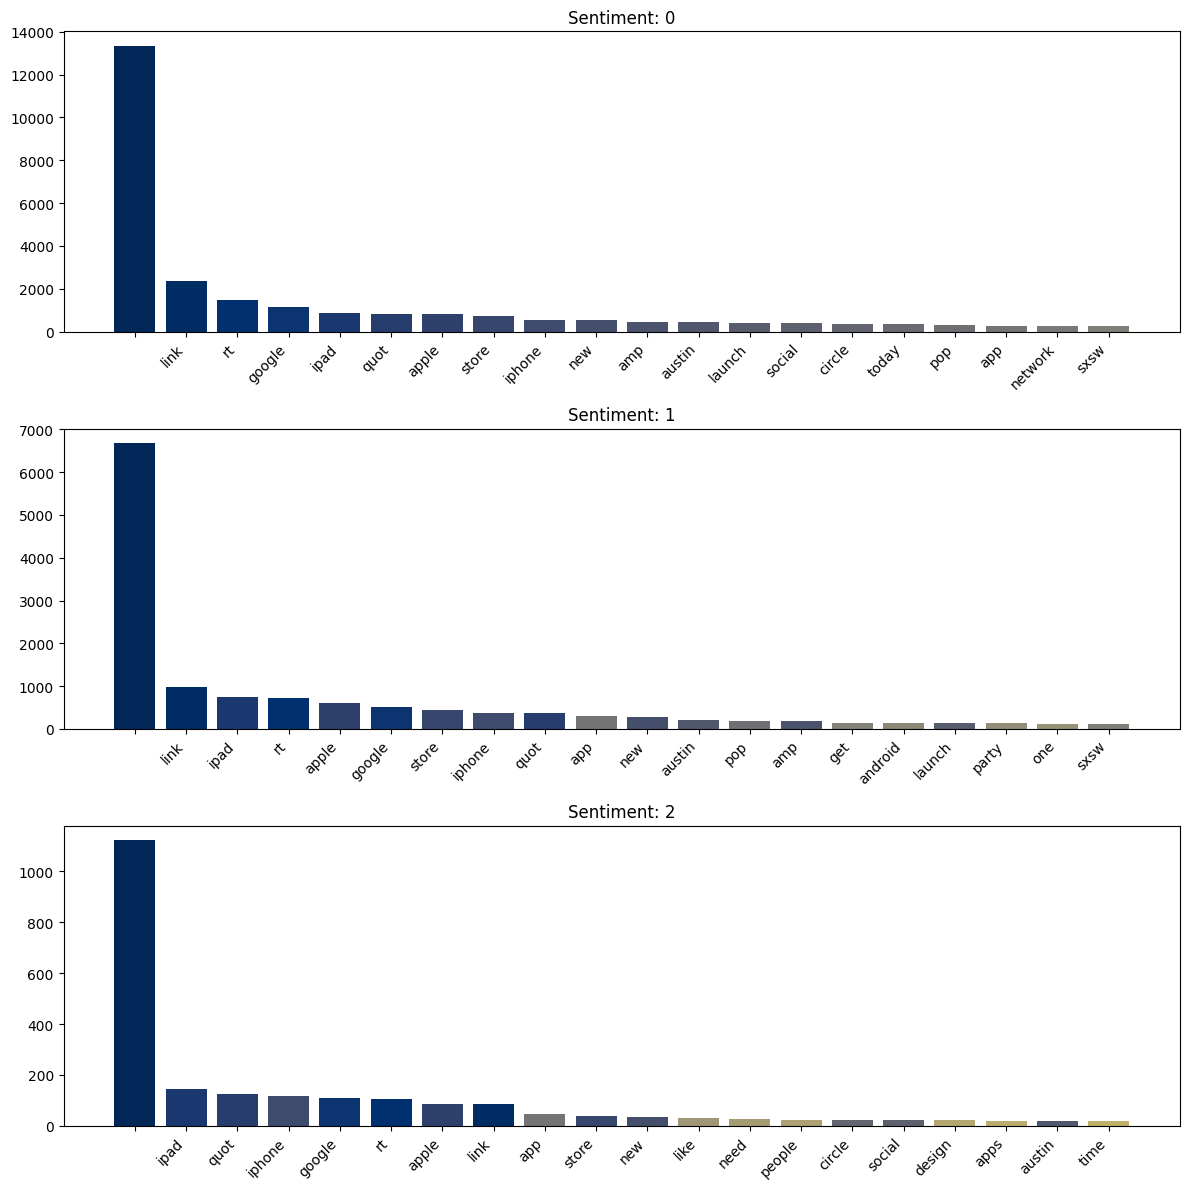

In [90]:
color_palette = sns.color_palette('cividis', n_colors=38)

fig, axes = plt.subplots(nrows=3, figsize=(12, 12)) 

plotted_words_and_colors = {}

sentiment_classes = y_train.unique() 
for i, sentiment_class in enumerate(sentiment_classes):
    sentiment_data = X_train2[y_train == sentiment_class]
    all_words_in_sentiment = [word for tokens in sentiment_data for word in tokens]
    top_10 = Counter(all_words_in_sentiment).most_common(20)
    
    colors = []
    
    for word, _ in top_10:
        if word not in plotted_words_and_colors:
            new_color = color_palette.pop(0)
            plotted_words_and_colors[word] = new_color
        colors.append(plotted_words_and_colors[word])
    
    ax = axes[i]
    words, counts = zip(*top_10)
    ax.bar(words, counts, color=colors)
    ax.set_title(f'Sentiment: {sentiment_class}') 
    ax.set_xticklabels(words, rotation=45, ha='right')

fig.tight_layout() 
plt.show()

In [91]:
#what if we only kept words that were verbs or adjectives